In [17]:
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [18]:
model = tf.keras.models.load_model(
    "./models/four_grayscale_image_trainset_V04_50epochs1653489725")


In [19]:
READ_PATH = "D:\\Main\\MA_PROGR\\Data\\Test\\4_Varianten\\women_half_alias"
WRITE_PATH = "D:\\Main\\MA_PROGR\\Data\\CNN_Output\\4_Varianten_out"
BUCKET_SIZE = 60


In [20]:
images = []
image_names = []
for file in os.listdir(READ_PATH):
    image_names.append(file)
    images.append(cv2.imread(
        "{}/{}".format(READ_PATH, file), cv2.IMREAD_GRAYSCALE))


In [21]:
IMG_WIDTH = images[0].shape[1]
IMG_HEIGHT = images[0].shape[0]


In [22]:
# image = cv2.imread("D:\\Main\\MA_PROGR\\Data\\number_grid.jpg")


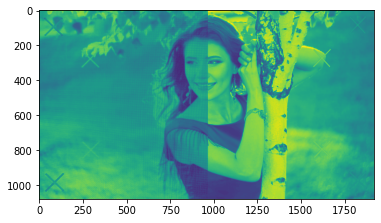

In [23]:
img = images[0]
# img = image
plt.imshow(img)

In [24]:
size_y = img.shape[0]
size_x = img.shape[1]
# size_y = image.shape[0]
# size_x = image.shape[1]

steps_horizontal = int(size_x/BUCKET_SIZE)
steps_vertikal = int(size_y/BUCKET_SIZE)

In [25]:
# steps_horizontal = 4
# steps_vertikal = 3
# start_idx = 0
# len_subset = 8
# end_idx = start_idx + len_subset

# y_start = 1
# x_start = 2


# for bucket_idx in range(start_idx, end_idx, 1):
#     x = bucket_idx % steps_horizontal
#     y = int((bucket_idx / steps_horizontal))
#     print(f"y_start: {y}, x_start: {x}")


In [26]:
# a = [[[1,2,3],[2,2,3]],[[3,3,3],[4,3,3]]]

# arr = np.asarray(a)
# arr.shape

In [27]:
# Loop through image, feed multiple buckets in model, sort results in 2D Array

img_puzz = np.full((steps_vertikal, steps_horizontal, BUCKET_SIZE, BUCKET_SIZE, 4), 0).tolist()

MAX_NUMBER_OF_BUCKETS_IN_BATCH = 20

start_idx = 0


def sort_into_alias_values(subset_of_alias_values, alias_values):

    subset_of_alias_values = np.asarray(subset_of_alias_values)
    global start_idx

    counter = 0

    len_subset = len(subset_of_alias_values)
    end_idx = start_idx + len_subset
    # subset_of_alias_values = subset_of_alias_values.reshape(len_subset, BUCKET_SIZE, BUCKET_SIZE, 3)

    for bucket_idx in range(start_idx, end_idx, 1):
        x = bucket_idx % steps_horizontal
        y = int((bucket_idx / steps_horizontal))

        

        alias_values[y][x] = subset_of_alias_values[counter]
        # img_puzz[y][x] = subset_of_alias_values[counter]
        # print(f"subset_of_alias_values[counter]: {subset_of_alias_values[counter]}")
        counter += 1

    start_idx += len_subset




def loop_through_image(four_images, alias_values):
    bucket_batch = []
    bucket_counter = 0
    subset_of_alias_values = 0
    sort_into_alias_values_was_called = False

    for y in range(int(steps_vertikal)):
        for x in range(int(steps_horizontal)):

            bucket = np.zeros(shape=(4, 60, 60, 1))

            for i, img in enumerate(four_images):
                tmp = img[y*BUCKET_SIZE:(y+1)*BUCKET_SIZE, x *
                          BUCKET_SIZE:(x+1)*BUCKET_SIZE]
                tmp = np.array(tmp).reshape(60,60,1)
                bucket[i] = tmp

            # print(f"bucket.shape: {bucket.shape}")
            bucket_batch.append(bucket.reshape(
                1, BUCKET_SIZE, BUCKET_SIZE, 4))

            bucket_counter += 1

            if bucket_counter == MAX_NUMBER_OF_BUCKETS_IN_BATCH:

                bucket_batch = np.array(bucket_batch)
                bucket_batch = bucket_batch.reshape(bucket_counter, 60, 60, 4)
                subset_of_alias_values = 1 - model.predict(bucket_batch)
                # print(f"subset of alias values: {subset_of_alias_values}")
                # subset_of_alias_values = bucket_batch
                sort_into_alias_values(subset_of_alias_values, alias_values)
                sort_into_alias_values_was_called = True
                bucket_counter = 0
                bucket_batch = bucket_batch.tolist()
                del bucket_batch[:]

    if not sort_into_alias_values_was_called:
        subset_of_alias_values = model.predict(bucket_batch)
        # subset_of_alias_values = bucket_batch
        sort_into_alias_values(subset_of_alias_values)



    return alias_values
    # ??


# loop_through_image(image)

# # Kontrolle, ob das Bild in der richtigen Reihenfolge wieder zusammengesetzt wird
# for y in range(steps_vertikal):
#     for x in range(steps_vertikal):
#         plt.imshow(img_puzz[y][x])
#         plt.show()


In [28]:
def create_tile(bucket_size, alias_value):
    myArray = np.zeros((BUCKET_SIZE, BUCKET_SIZE))
    for y in range(bucket_size):
        for x in range(bucket_size):
            myArray[y][x] = alias_value

    return myArray



In [29]:
def create_grayscale_img(four_imgages):

    global start_idx
    horizontal_stripes = []
    horizontal_result = 0
    final_result = 0

    alias_values = np.full((steps_vertikal, steps_horizontal), 0).tolist()
    alias_values = loop_through_image(four_imgages, alias_values)
    start_idx = 0

    # print(f"alias_values: {np.array(alias_values).shape}")

    for y in range(int(steps_vertikal)):
        for x in range(int(steps_horizontal)):
            # print("x: {}".format(x))
            if x == 0:
                horizontal_result = create_tile(BUCKET_SIZE, alias_values[y][x])
                plt.imshow(horizontal_result)
                continue
            horizontal_result = np.concatenate(
                (horizontal_result, create_tile(BUCKET_SIZE, alias_values[y][x])), axis=1)
        if y == 0:
            final_result = horizontal_result
            continue
        final_result = np.concatenate((final_result, horizontal_result))
        horizontal_result = 0

    return final_result

    # plt.imshow(final_result, cmap="gray")
    # plt.show()




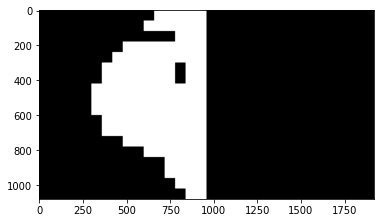

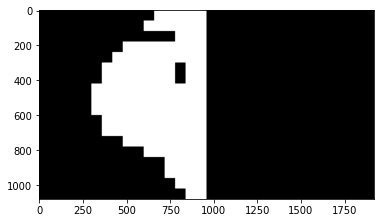

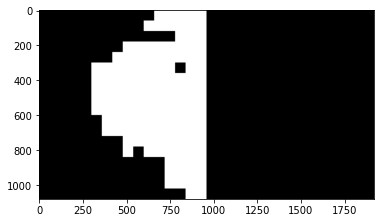

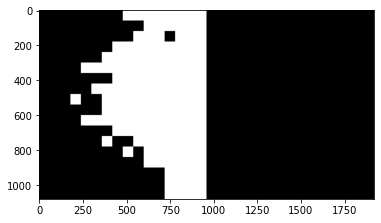

In [30]:


grayscale_images = []
del grayscale_images[:]


for i, img in enumerate(images):
    # if i == (len(images)-4):
    #     break
    grayscale_image = create_grayscale_img(images[i:i+4])
    plt.imshow(grayscale_image, cmap="gray")
    plt.show()
    grayscale_images.append(grayscale_image)


In [31]:
# for i, grayscale_image in enumerate(grayscale_images):
#     cv2.imwrite(f"{WRITE_PATH}//{image_names[1]}", grayscale_image)

In [32]:

plt.imsave(f"{WRITE_PATH}//haha.png", grayscale_images[0], cmap='gray')
